In [1]:
# importing modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(22)
from math import sqrt
from datetime import datetime
import altair as alt
import torch
torch.manual_seed(0)

In [ ]:
# wandb cell

# we have used the reports and graphs generateed in the wandb
# dashboard directly in the code as well as report.

!pip install wandb
import wandb

wandb.login()

# there are cells below all models we have trained that will log in the
# details of each run into the wandb dashboard

wandb: Currently logged in as: ck20 (use `wandb login --relogin` to force relogin)


True

In [3]:
# reading the dataset
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          426 non-null    object 
 1   new_cases     426 non-null    int64  
 2   total_cases   426 non-null    int64  
 3   active_cases  426 non-null    float64
 4   mobilty       426 non-null    float64
 5   dose1         426 non-null    int64  
 6   dose2         426 non-null    int64  
 7   new_deaths    426 non-null    int64  
 8   total_deaths  426 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 30.1+ KB


In [20]:
df.head()

,date,new_cases,total_cases,active_cases,mobilty,dose1,dose2,new_deaths,total_deaths
0,2020-02-11,1,1,1.0,109.07,0,0,0,0
1,2020-02-12,0,1,0.0,111.20,0,0,0,0
2,2020-02-13,0,1,0.0,110.18,0,0,0,0
3,2020-02-14,0,1,0.0,123.91,0,0,0,0
4,2020-02-15,0,1,0.0,131.79,0,0,0,0


## Data pre-processing

Most of the pre-processing was done at the time of scraping the data insdie their respective folders. The code is included withing the respective scrape files. Once all the data was collected, it was accumulated inside a "data.csv" file. Since the number of data points were relatively small, doing it like this instead of here was faster and more convinient

## Data visualization

Below we visualize all the features to get the feel of the trends and a high level overview of our dataset

We start with individual plots and then go on to build a combined plot using Altair library

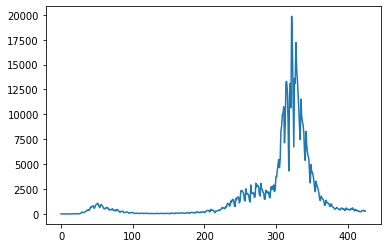

In [ ]:
plt.plot(df['new_cases'])
plt.show()

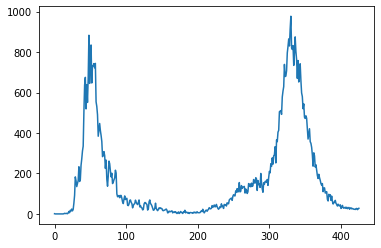

In [ ]:
plt.plot(df['active_cases'])
plt.show()

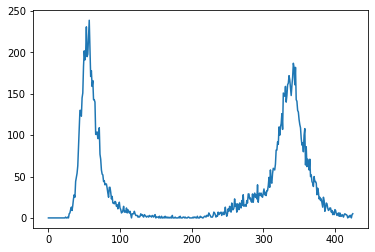

In [ ]:
plt.plot(df['new_deaths'])
plt.show()

From the above two graphs, there seems to be a similarity b/w new deaths and active cases in London

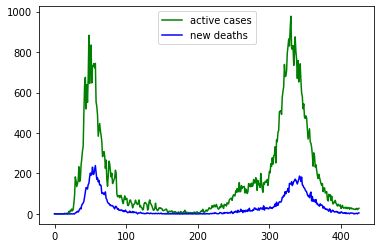

In [ ]:
# plotting them together
fig, ax = plt.subplots()
ax.plot(df['active_cases'], 'g', label='active cases')
ax.plot(df['new_deaths'], 'b', label='new deaths')
leg = ax.legend()

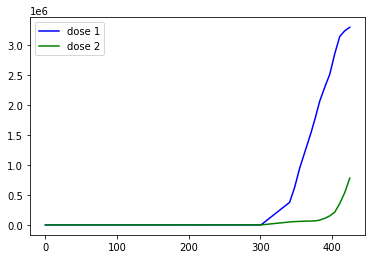

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['dose1'], 'b', label='dose 1')
ax.plot(df['dose2'], 'g', label='dose 2')
leg = ax.legend()

In [ ]:
alt.Chart(df).mark_circle().encode(
    x='date:T',
    y='mobilty',
    size=alt.Size('mobilty',
        scale=alt.Scale(range=[0,500]),
        legend=alt.Legend(title='Daily mobilty')
    )
).properties(
    width=3000,
    height=300
)

alt.Chart(...)

In [ ]:
interval = alt.selection_interval()
circle = alt.Chart(df).mark_circle().encode(
    x='date:O',
    size=alt.Size('new_cases:Q',
        scale=alt.Scale(range=[0, 3000]),
        legend=alt.Legend(title='Daily new cases')
    ) 
).properties(
    width=3000,
    height=300,
    selection=interval
)

bars = alt.Chart(df).mark_bar().encode(
    x='sum(new_cases):Q'
).properties(
    width=1000
).transform_filter(
    interval
)

circle & bars

alt.VConcatChart(...)

## Problem and our approach

We set out to identify the relationship b/w "new deaths" per day and "active cases" per day. We thouight we should be able to even use one to predict another. However, on the way, we realized, due the lack of data and even otherwise, we should also take cues for predicting new cases in future from the cases reported in previous few weeks. So the task of out model will be to be able to forcast upcoming cases in the area of London.

### Data preparation

Here we prepare our dataset, split it into test, training and holdout sets and then scale them. The other pre-processing was done during scraping of the data in their respective scrape files and the data.csv was combined manually in Excel since it was easier to do it there.

In [4]:
# creating a new dataset based on active cases since the past past 25 days
# and using them as features

date = df['date'].tolist()
new_cases = df['new_cases'].tolist()
mob = df['mobilty'].tolist()
dose1 = df['dose1'].tolist()
dose2 = df['dose2'].tolist()
new_deaths = df['new_deaths'].tolist()
active_cases = df['active_cases'].tolist()

n = len(date)
past = 25

X = np.zeros((n-past, 2*past+3))
y = np.zeros((n-past, 1))

for i in range(n-past):
    tmp = np.zeros(2*past+3)
    tmp[:past] = new_cases[i:i+past]
    tmp[past:2*past] = new_deaths[i:i+past]
    tmp[2*past] = mob[i+past]
    tmp[2*past+1] = dose1[i+past]
    tmp[2*past+2] = dose2[i+past]
    X[i] = tmp
    y[i] = active_cases[i+past]

cols = [f'cases_day_{i}' for i in range(1, past+1)]
cols += [f'deaths_day_{i}' for i in range(1, past+1)]
cols.append('mobility')
cols.append('dose1')
cols.append('dose2')

X = pd.DataFrame(X, columns=cols)
X['date'] = date[past:]
print(X.shape, y.shape)
print(X.head())

(401, 54) (401, 1)
   cases_day_1  cases_day_2  cases_day_3  ...  dose1  dose2        date
0          1.0          0.0          0.0  ...    0.0    0.0  2020-03-07
1          0.0          0.0          0.0  ...    0.0    0.0  2020-03-08
2          0.0          0.0          0.0  ...    0.0    0.0  2020-03-09
3          0.0          0.0          0.0  ...    0.0    0.0  2020-03-10
4          0.0          0.0          0.0  ...    0.0    0.0  2020-03-11

[5 rows x 54 columns]


In [5]:
# holding out last few rows for prediction

hold = 7
X_hold = X.tail(7)
date_hold = X_hold['date']
X_hold.drop(['date'], inplace=True, axis=1)
print(X_hold)
X = X.iloc[:-7]
print(X.tail())

y_hold = y[-7:]
print(len(y_hold), y_hold)
y = y[:-7]
print(len(y))

     cases_day_1  cases_day_2  cases_day_3  ...  mobility      dose1     dose2
394        453.0        509.0        363.0  ...     64.44  3244337.0  573480.0
395        509.0        363.0        362.0  ...     68.60  3252798.0  608001.0
396        363.0        362.0        596.0  ...     69.83  3261259.0  642522.0
397        362.0        596.0        505.0  ...     67.72  3269720.0  677043.0
398        596.0        505.0        453.0  ...     69.65  3278181.0  711564.0
399        505.0        453.0        475.0  ...     67.18  3286642.0  746085.0
400        453.0        475.0        441.0  ...     72.76  3295103.0  780606.0

[7 rows x 53 columns]
     cases_day_1  cases_day_2  cases_day_3  ...      dose1     dose2        date
389        400.0        407.0        562.0  ...  3181984.0  435359.0  2021-03-31
390        407.0        562.0        590.0  ...  3195457.0  461259.0  2021-04-01
391        562.0        590.0        528.0  ...  3208930.0  487159.0  2021-04-02
392        590.0     

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# seperate out the dates
date_train = X_train['date']
X_train.drop(['date'], inplace=True, axis=1)
date_test = X_test['date']
X_test.drop(['date'], inplace=True, axis=1)

scx = StandardScaler()
scy = StandardScaler()
X_train_std = scx.fit_transform(X_train)
X_test_std = scx.transform(X_test)
y_train_std = scy.fit_transform(y_train)
y_test_std = scy.transform(y_test)

# reshaping the target vector y
y_train_std = np.squeeze(y_train_std)
y_test_std = np.squeeze(y_test_std)
print(X_train_std.shape, X_test_std.shape, y_train_std.shape, y_test_std.shape)

(295, 53) (99, 53) (295,) (99,)


### SVR model

below cells are relating to SVR model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

reg = SVR()

param_grid = {
    'kernel': ['rbf', 'poly',],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 1.0],
    'tol': [1e-5, 1e-3, 0.005, 0.1],
    'C': [0.0001, 0.005, 0.01, 0.1, 1.0],
    'epsilon': [0.5, 0.1, 0.01, 0.001]
}

gridsearch = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error').fit(X_train_std, y_train_std)
print('Best score: ', gridsearch.best_score_, 'with params: ', gridsearch.best_params_)

Best score:  -0.19330863377415944 with params:  {'C': 1.0, 'coef0': 1.0, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly', 'tol': 0.1}


In [16]:
# training the SVR model

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# best params from GridSearch
# {'C': 1.0, 'coef0': 1.0, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly', 'tol': 0.1}
svr = SVR(kernel='poly', C=1.0, coef0=1.0, epsilon=0.01, tol=0.1, degree=3)
svr.fit(X_train_std, y_train_std)
y_pred = svr.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred))
print(rmse)
print(svr.score(X_test_std, y_test_std))

0.1708923138006611
0.9577454916905358


In [ ]:
# wandb log cell

proj = 'final_submission'
team_name = 'pct101'
run_name = 'SVR'
wandb.init(project=proj, entity=team_name, name=run_name)

wandb.sklearn.plot_regressor(svr, X_train_std, X_test_std, y_train_std, y_test_std,  model_name=run_name)

_runtime,5
_timestamp,1619780625
_step,1


_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: 
wandb: Plotting SVR.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


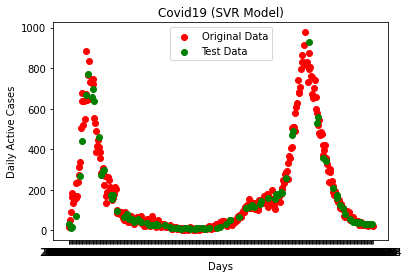

In [56]:
# plot the regression fit with original data
y_pred_plt = np.array(scy.inverse_transform(y_pred))
y_pred_plt = y_pred_plt.reshape((-1, 1))
y_test_std = y_test_std.reshape((-1, 1))
y_train_std = y_train_std.reshape((-1, 1))
y_plt = y.reshape((-1, 1))

plt.scatter(date[past:-7], y_plt, color = 'red', label = 'Original Data')
plt.scatter(date_test.values, y_pred_plt, color = 'green', label = 'Test Data')
plt.title('Covid19 (SVR Model)')
plt.xlabel('Days')
plt.ylabel('Daily Active Cases')
plt.legend()
plt.show()

Results for Linear Regression model (should be pretty close to SVR model)
0.27309515471487805
0.8920914188148339
Feature: 0, Score: 0.05507
Feature: 1, Score: 0.15763
Feature: 2, Score: 0.08215
Feature: 3, Score: -0.17058
Feature: 4, Score: -0.11063
Feature: 5, Score: -0.03834
Feature: 6, Score: -0.01970
Feature: 7, Score: 0.03955
Feature: 8, Score: -0.04601
Feature: 9, Score: 0.08735
Feature: 10, Score: -0.02200
Feature: 11, Score: 0.14772
Feature: 12, Score: 0.01475
Feature: 13, Score: -0.17561
Feature: 14, Score: -0.06549
Feature: 15, Score: -0.05083
Feature: 16, Score: -0.07026
Feature: 17, Score: 0.03070
Feature: 18, Score: 0.05011
Feature: 19, Score: 0.09877
Feature: 20, Score: 0.11228
Feature: 21, Score: 0.13007
Feature: 22, Score: 0.05003
Feature: 23, Score: 0.07401
Feature: 24, Score: 0.02172
Feature: 25, Score: -0.17211
Feature: 26, Score: -0.05823
Feature: 27, Score: 0.05324
Feature: 28, Score: 0.21309
Feature: 29, Score: 0.13571
Feature: 30, Score: 0.10518
Feature: 31, Scor

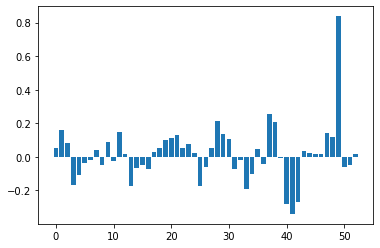

In [57]:
# extracting feature importance
# NOTE: We cannot extract feature importance from a SRV model since the feautures
# in it are transformed to another plane and hence are modified before prediction.
# Hence we make use of a "Linear Regression" model

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_std, y_train_std)
y_pred_fi = reg.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred_fi))
print('Results for Linear Regression model (should be pretty close to SVR model)')
print(rmse)
print(reg.score(X_test_std, y_test_std))

# summarize feature importance
importance = reg.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Clearly as can be seen, the most important feature is in fact previous day death count. The other features have comparatively lesser importance in the prediction of current days active cases

In [17]:
# predicitons

X_hold_ = scx.transform(X_hold)
future = svr.predict(X_hold_)
future = np.array(scy.inverse_transform(future))
future = map(int, future)
print('upcoming 7 days active cases as predicted by SVR model:\n', *future)
print('actual active cases from the dataset:\n', *y_hold)

upcoming 7 days active cases as predicted by SVR model:
 31 33 34 38 39 36 47
actual active cases from the dataset:
 [23.] [22.] [26.] [27.] [21.] [25.] [28.]


### 2-layered NN model

Below cells are related to the 2-layers NN model

In [7]:
X_train_nn = torch.from_numpy(X_train_std.astype(np.float32)).view(X_train_std.shape[0], 53)
X_test_nn = torch.from_numpy(X_test_std.astype(np.float32)).view(X_test_std.shape[0], 53)
y_train_nn = torch.from_numpy(y_train_std.astype(np.float32)).view(X_train_std.shape[0],1)
y_test_nn = torch.from_numpy(y_test_std.astype(np.float32)).view(X_test_std.shape[0],1)

In [18]:
min_loss=1000
layer = 80 #159 mse loss = 0.1589 on test set and 0.018 on train set; 106 mse loss 0.1465 on test set and 0.019 on train
epochs = 40000

modelx = torch.nn.Sequential(
    torch.nn.Linear(53, layer),
    torch.nn.ReLU(),
    torch.nn.Linear(layer, layer),
    torch.nn.ReLU(),
    torch.nn.Linear(layer, 1),
)
loss_fn = torch.nn.MSELoss()
# wandb.watch(modelx, log_freq=100)

learning_rate = 1e-3
optimizer = torch.optim.RMSprop(modelx.parameters(), lr=learning_rate)

start_time = datetime.now()

for t in range(epochs):
    y_pred = modelx(X_train_nn)

    RMSE_loss = torch.sqrt(loss_fn(y_pred, y_train_nn))
    
    optimizer.zero_grad()

    RMSE_loss.backward()

    optimizer.step()

    if t%100 == 99:
        print(t+1, RMSE_loss.item())
        # wandb.log({"loss": RMSE_loss})

y1_pred = modelx(X_test_nn).detach()
print(y1_pred.shape)
print(torch.sqrt(loss_fn(y1_pred, y_test_nn)))

100 0.14027388393878937
200 0.12075167894363403
300 0.12469968944787979
400 0.09942975640296936
500 0.09097249805927277
600 0.08525021374225616
700 0.0830957442522049
800 0.12185010313987732
900 0.08272694796323776
1000 0.07110214233398438
1100 0.09466314315795898
1200 0.07301391661167145
1300 0.07332801073789597
1400 0.056352272629737854
1500 0.06714174896478653
1600 0.050022587180137634
1700 0.06709873676300049
1800 0.05472681671380997
1900 0.0595649890601635
2000 0.044829946011304855
2100 0.060739994049072266
2200 0.05097297951579094
2300 0.06618978828191757
2400 0.05408245697617531
2500 0.05966578796505928
2600 0.04913837090134621
2700 0.05962279438972473
2800 0.06372781097888947
2900 0.059358906000852585
3000 0.04825139418244362
3100 0.04626178741455078
3200 0.04700877144932747
3300 0.05007665604352951
3400 0.05110260099172592
3500 0.06503321975469589
3600 0.042530607432127
3700 0.049802690744400024
3800 0.05130253732204437
3900 0.0474337600171566
4000 0.06544821709394455
4100 0.0

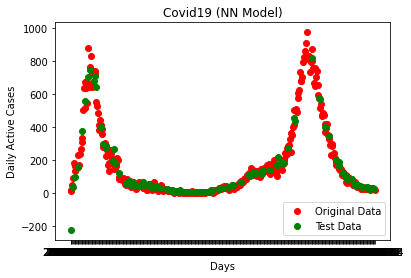

In [14]:
# plot the fit with original data
y1_pred_plt = np.array(scy.inverse_transform(y1_pred))
y1_pred_plt = y1_pred_plt.reshape((-1, 1))
y_plt = y.reshape((-1, 1))

plt.scatter(date[past:-7], y_plt, color = 'red', label = 'Original Data')
plt.scatter(date_test.values, y1_pred_plt, color = 'green', label = 'Test Data')
plt.title('Covid19 (NN Model)')
plt.xlabel('Days')
plt.ylabel('Daily Active Cases')
plt.legend()
plt.show()

In [19]:
# predicitons

X_hold_ = scx.transform(X_hold)
X_hold_ = torch.from_numpy(X_hold_.astype(np.float32)).view(7, 53)
future = modelx(X_hold_).detach()
future = np.array(scy.inverse_transform(future))
future = map(int, future)
print('upcoming 7 days active cases as predicted by NN:\n', *future)
print('actual active cases from the dataset:\n', *y_hold)

upcoming 7 days active cases as predicted by NN:
 26 29 28 26 26 22 24
actual active cases from the dataset:
 [23.] [22.] [26.] [27.] [21.] [25.] [28.]


### Other models we tried

Below cells include other models that we gave a spin. These include: **LinearRegression** model and **Prophet** model

#### Linear Regression

In [88]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_std, y_train_std)
y_pred = reg.predict(X_test_std)
rmse = sqrt(mean_squared_error(y_test_std, y_pred))
print(rmse)
print(reg.score(X_test_std, y_test_std))

0.27309515471487805
0.8920914188148339


In [ ]:
# wandb log cell

proj = 'final_submission'
team_name = 'pct101'
run_name = 'LR'
wandb.init(project=proj, entity=team_name, name=run_name)

wandb.sklearn.plot_regressor(reg, X_train_std, X_test_std, y_train_std, y_test_std,  model_name=run_name)

_runtime,7
_timestamp,1619780864
_step,3


_runtime,▁▅▆█
_timestamp,▁▅▆█
_step,▁▃▆█


wandb: 
wandb: Plotting LR.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


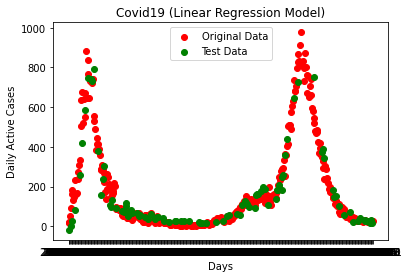

In [ ]:
# plot the regression fit with original data
y_pred_plt = np.array(scy.inverse_transform(y_pred))
y_pred_plt = y_pred_plt.reshape((-1, 1))
y_test_std = y_test_std.reshape((-1, 1))
y_train_std = y_train_std.reshape((-1, 1))
y_plt = y.reshape((-1, 1))

plt.scatter(date[past:-7], y_plt, color = 'red', label = 'Original Data')
plt.scatter(date_test.values, y_pred_plt, color = 'green', label = 'Test Data')
plt.title('Covid19 (Linear Regression Model)')
plt.xlabel('Days')
plt.ylabel('Daily Active Cases')
plt.legend()
plt.show()

In [89]:
# predicitons

X_hold_ = scx.transform(X_hold)
future = reg.predict(X_hold_)
future = np.array(scy.inverse_transform(future))
future = map(int, future)
print('upcoming 7 days active cases as predicted by LR model:\n', *future)
print('actual active cases from the dataset:\n', *y_hold)

upcoming 7 days active cases as predicted by LR model:
 15 27 22 42 36 20 38
actual active cases from the dataset:
 [23.] [22.] [26.] [27.] [21.] [25.] [28.]


#### Prophet

In [ ]:
from fbprophet import Prophet

new_df = df[['date', 'total_cases']]
new_df.columns = ['ds', 'y']

model = Prophet(interval_width=0.95)
model.fit(new_df)
future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds           yhat     yhat_lower    yhat_upper
511 2021-07-06  855582.116280  510810.812641  1.211793e+06
512 2021-07-07  857042.415886  510437.870195  1.217942e+06
513 2021-07-08  858319.654380  497396.656355  1.230059e+06
514 2021-07-09  859366.779165  485803.624695  1.242462e+06
515 2021-07-10  860514.912645  491245.865626  1.243649e+06


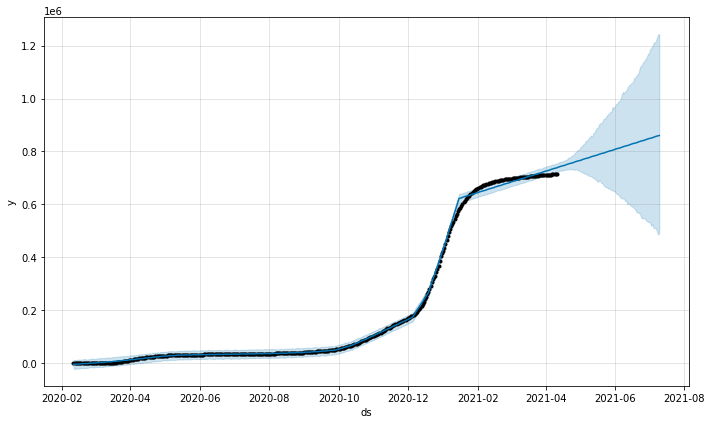

In [ ]:
confirmed_forecast_plot = model.plot(forecast)

The total cases as seen from the Prophet model will grimly continue to rise althouth at a far lower rate

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)